In [3]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from keras.callbacks import Callback

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

Using Theano backend.


In [4]:
# Load the data in from the serialized array
# Font data is sorted in 4D arrays of shape (770, 1, 60, 1300)
x_data = np.load(file='test_font_arr.npy')
y_data = np.load(file='font_arr.npy')

# x_data = x_data[:100]
# y_data = y_data[:100]

x_train = x_data[:len(x_data) * 0.9]
x_validation = x_data[len(x_data) * 0.9:]

y_train = y_data[:len(y_data) * 0.9]
y_validation = y_data[len(y_data) * 0.9:]


/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


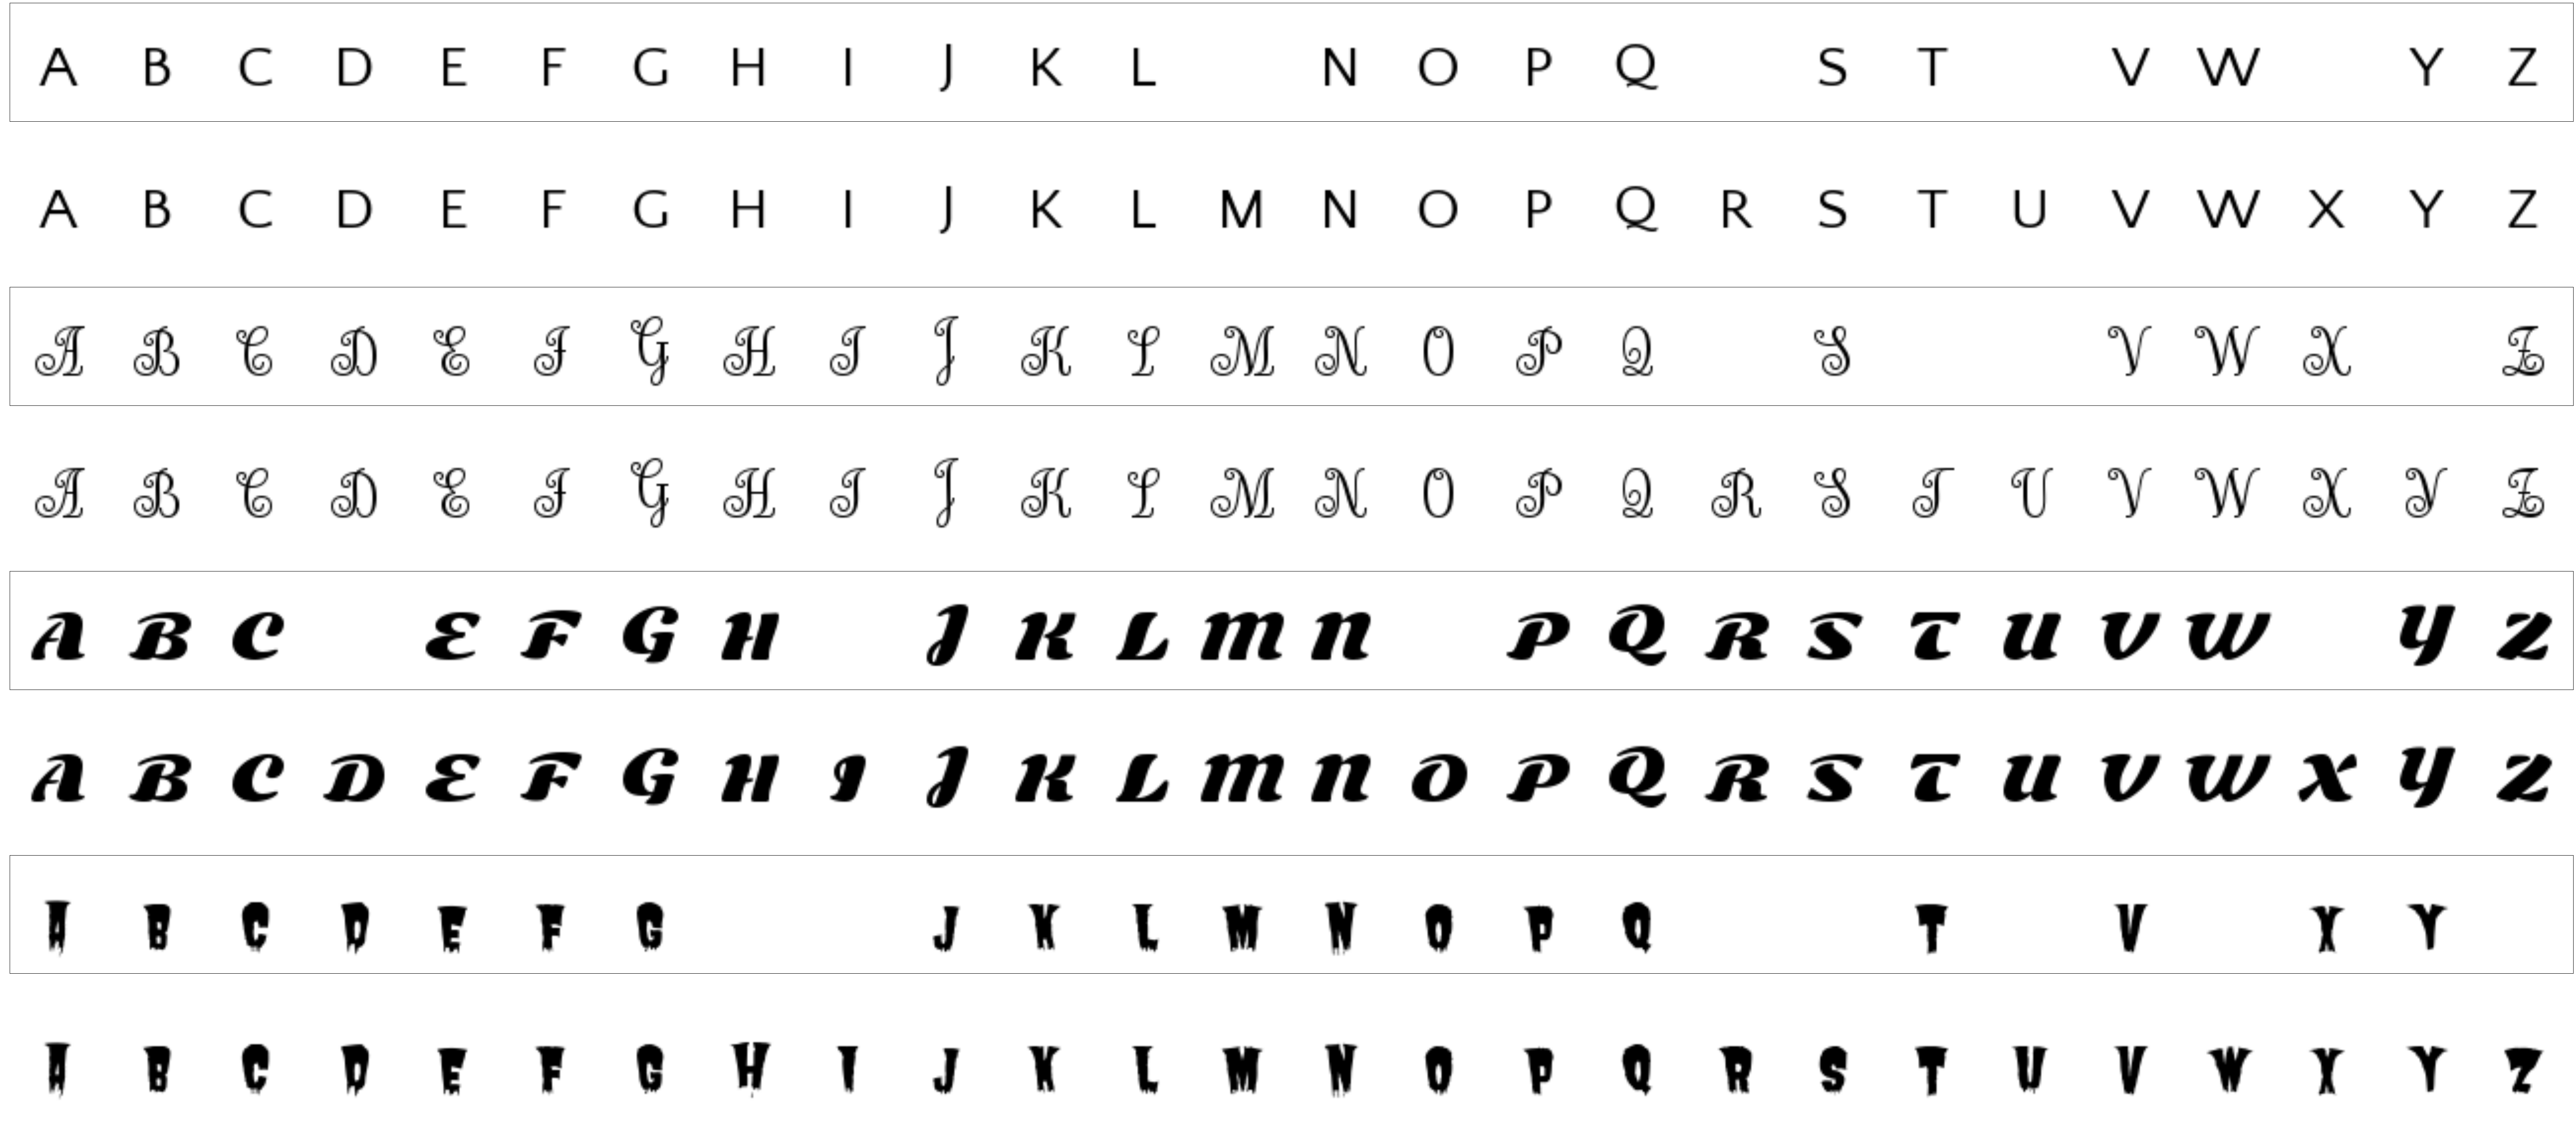

In [5]:
n = 4
plt.figure(figsize=(120, 100))
cnt = 1
for i in range(1,n+1):  
    # display input
    ax = plt.subplot(n*4, 1, cnt)
    plt.imshow(x_validation[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
    
    # display desired output
    ax = plt.subplot(n*4, 1, cnt).axis('off')
    plt.imshow(y_validation[i].reshape(60, 1300))
    plt.gray()
    cnt+=1
plt.show()

In [32]:
# Runs 32 different kernels through the image
num_filters = 32

# 3x3 kernel size
kernel_x = 3
kernel_y = 3

# Downscale the image by a factor of 2 each pooling layer
pooling_factors = (2,2)

In [44]:
input_img = Input(shape=(1, 60, 1300), name='Input image')

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #1')(input_img)
x = MaxPooling2D(pooling_factors, border_mode='same', name='Pooling layer #1')(x)
# x = Dropout(0.25)(x)
x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #2')(x)
x = MaxPooling2D(pooling_factors, border_mode='same', name='Pooling layer #2')(x)
# data is (32, 15, 325)

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Encoding conv #3')(x)
encoded = MaxPooling2D((3,5), border_mode='same', name='Encoding pooling layer')(x)
# data is (32, 3, 65)

# at this point the representation is (32, 15, 325)
# EACH FILTER ADDS A DIMENSION!!!!

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #1')(encoded)
x = UpSampling2D((3,5), name='Upsampling layer #1')(x)
# data is (32, 15, 325)

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #2')(x)
x = UpSampling2D(pooling_factors, name='Upsampling layer #2')(x)

x = Convolution2D(num_filters, kernel_x, kernel_y, activation='relu', border_mode='same', name='Decoding conv #3')(x)
x = UpSampling2D(pooling_factors, name='Upsampling layer #3')(x)

decoded = Convolution2D(1, kernel_x, kernel_y, activation='sigmoid', border_mode='same', name='Piece-together conv layer')(x)
# THE NUMBER OF KERNELS HERE IS 1 BECAUSE THAT WAY IT OUTPUTS A SINGLE DIMENSION (CHANNEL)

# Compiles the model diagram described above into a neural network
autoencoder = Model(input=input_img, output=decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# How many training cycles the program does
num_epoch = 50

# How many images to process before backpropagating
batch_size = 4

In [52]:
print('Batch size:', batch_size,'\nNumber of epochs:', num_epoch)
start = time.time()
train = autoencoder.fit(x_train, y_train,
                nb_epoch=num_epoch,
                batch_size=batch_size,
                validation_data=(x_validation, y_validation))
end = time.time()

m, s = divmod(end - start, 60)
print('Total time elapsed:', str(int(m)), 'minutes,', str(s)[:str(s).find('.')], 'seconds')

Batch size: 4 
Number of epochs: 50
Train on 692 samples, validate on 77 samples
Epoch 1/50
692/692 [==============================] - 182s - loss: 0.1385 - acc: 0.9328 - val_loss: 0.1362 - val_acc: 0.9300
Epoch 2/50
692/692 [==============================] - 175s - loss: 0.1487 - acc: 0.9314 - val_loss: 0.1776 - val_acc: 0.9263
Epoch 3/50
692/692 [==============================] - 175s - loss: 0.1506 - acc: 0.9329 - val_loss: 0.1752 - val_acc: 0.9270
Epoch 4/50
692/692 [==============================] - 180s - loss: 0.1494 - acc: 0.9330 - val_loss: 0.1680 - val_acc: 0.9296
Epoch 5/50
692/692 [==============================] - 181s - loss: 0.1575 - acc: 0.9310 - val_loss: 0.1563 - val_acc: 0.9301
Epoch 6/50
692/692 [==============================] - 182s - loss: 0.1669 - acc: 0.9307 - val_loss: 0.1652 - val_acc: 0.9300
Epoch 7/50
692/692 [==============================] - 195s - loss: 0.1648 - acc: 0.9323 - val_loss: 0.1859 - val_acc: 0.9304
Epoch 8/50
692/692 [========================

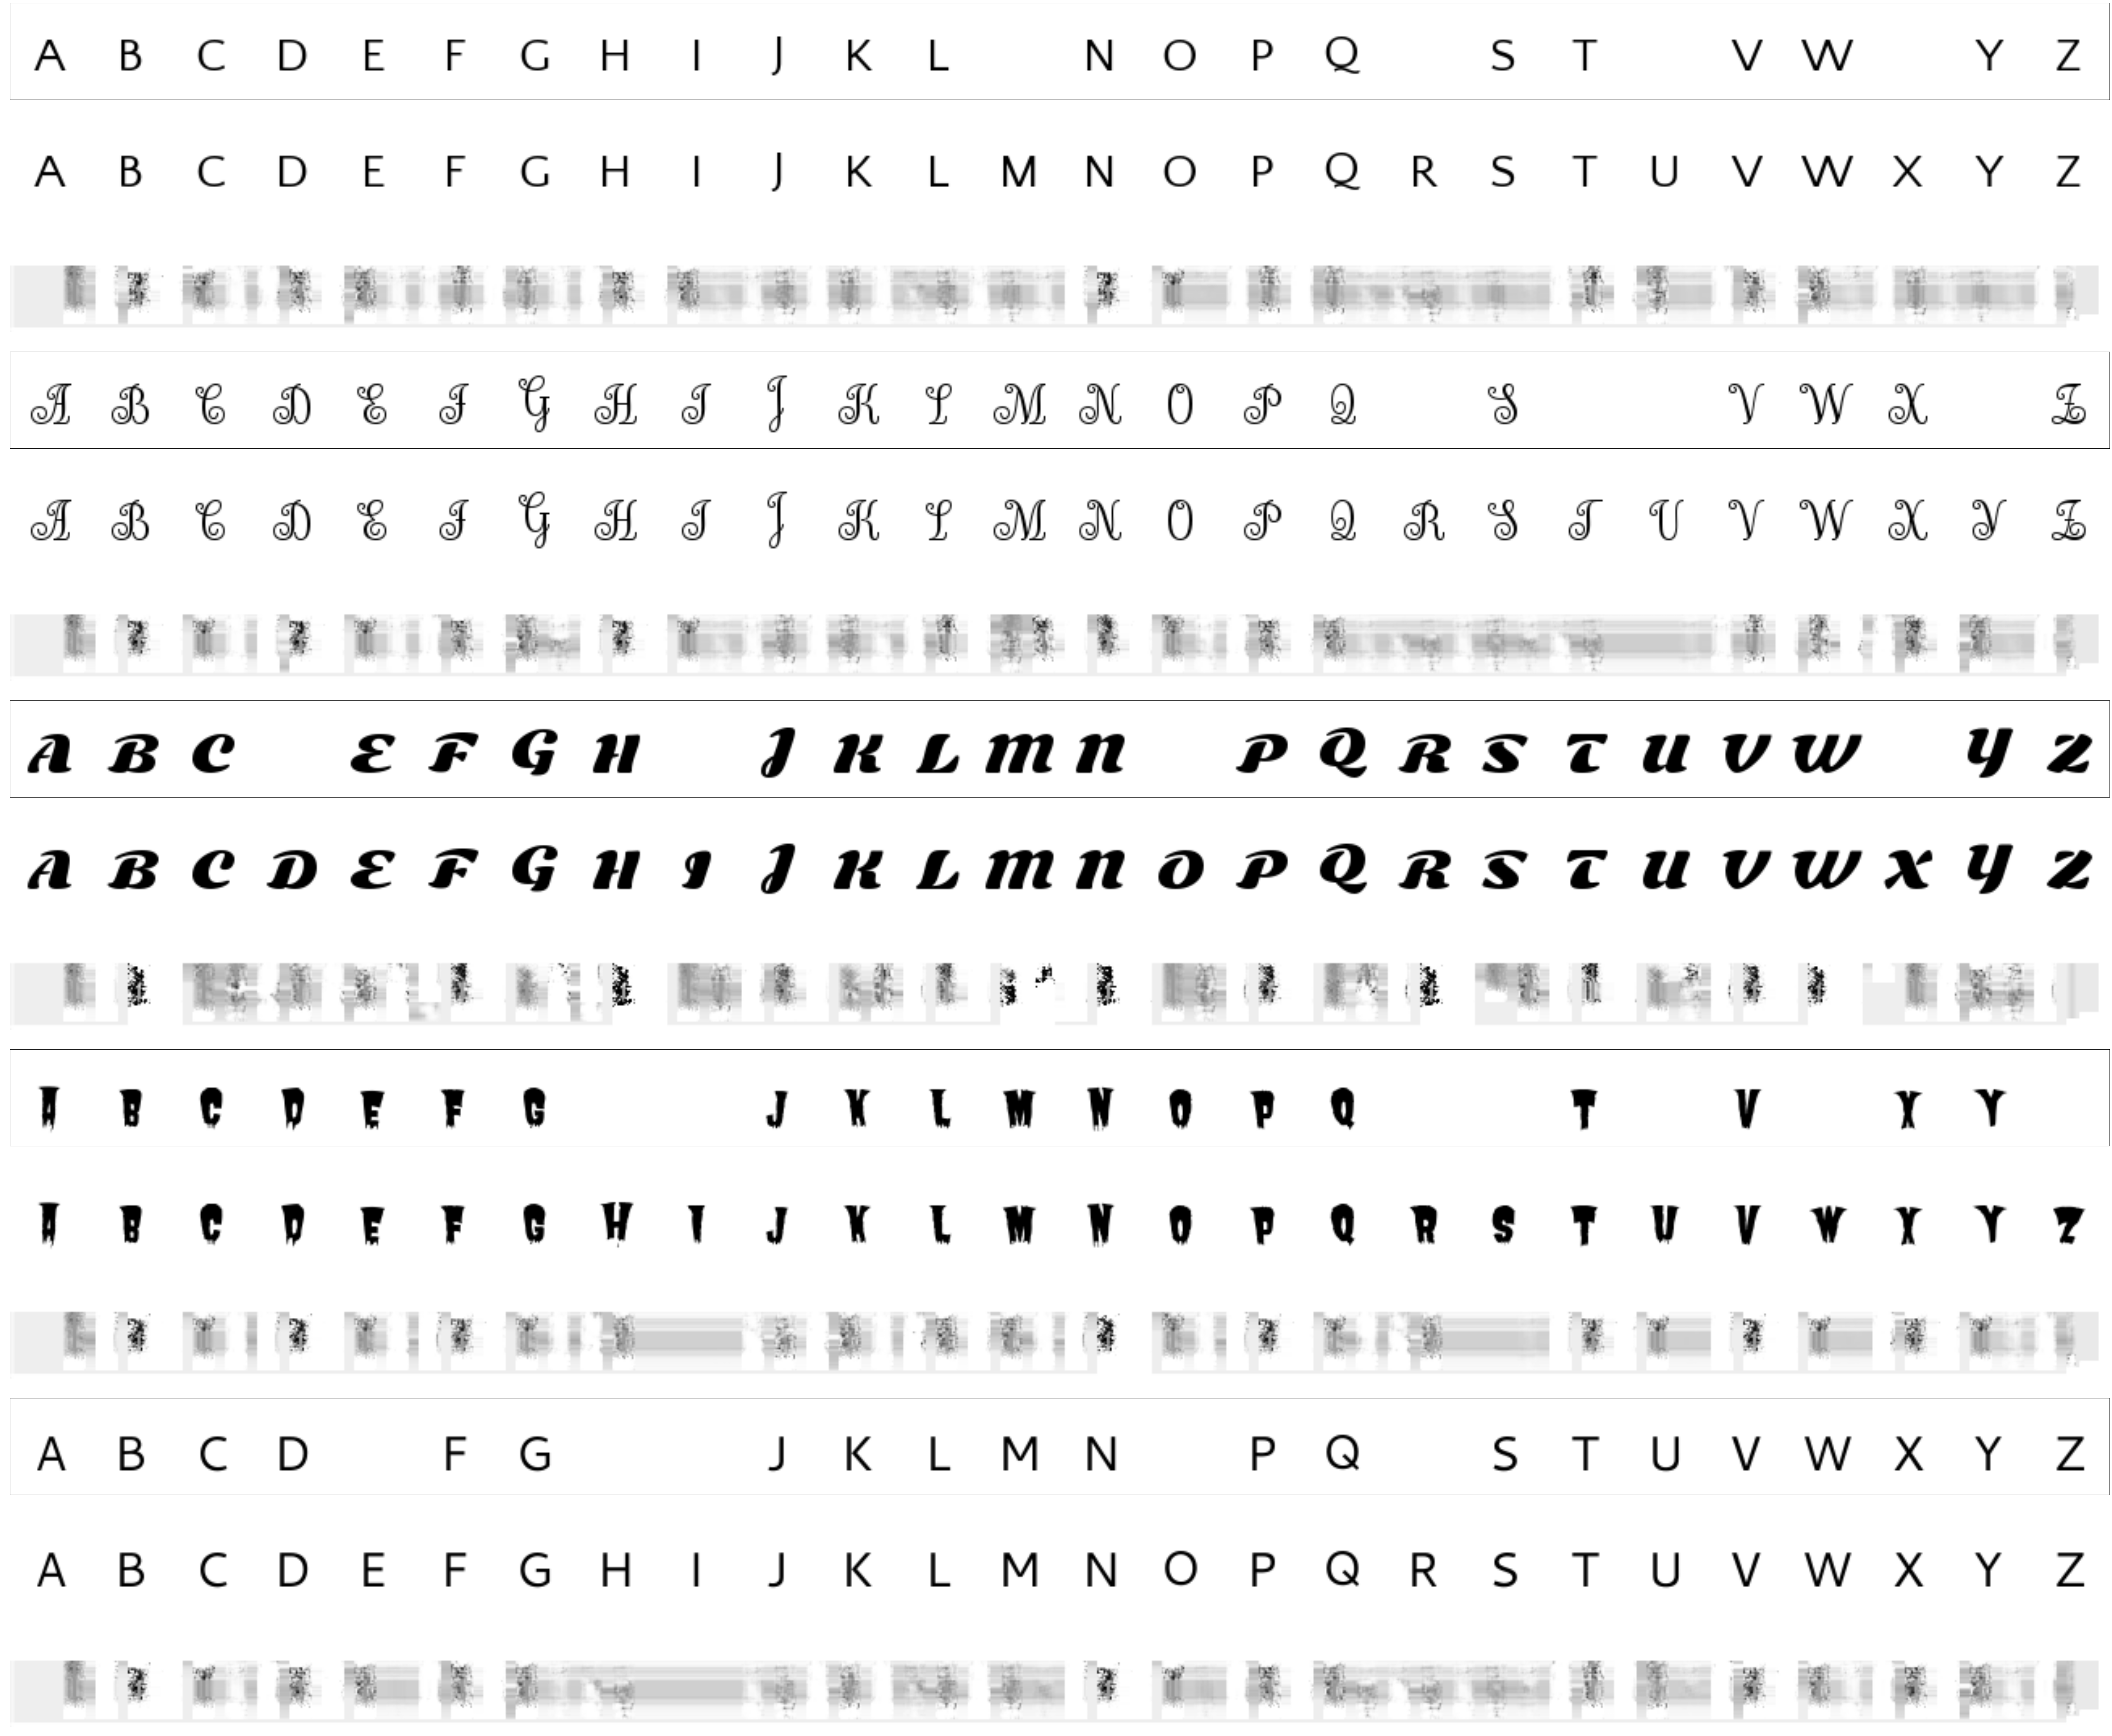




Blank image:


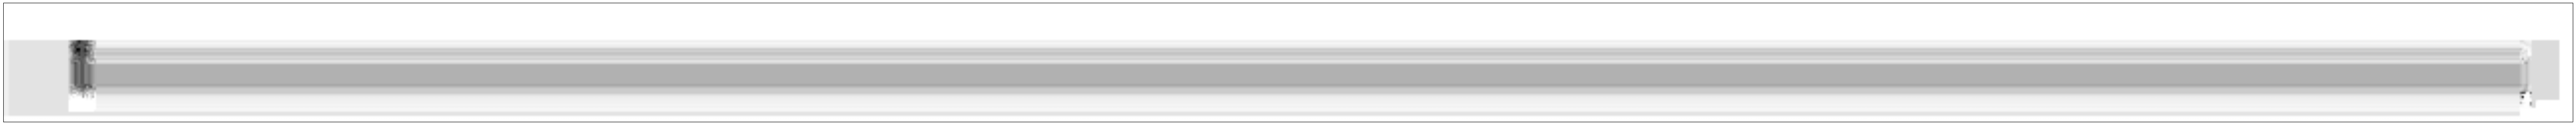

In [53]:
n = 5
decoded_imgs = autoencoder.predict(x_validation[:n+1])
plt.figure(figsize=(120, 100))
cnt = 1
for i in range(1,n+1):
    # display input
    ax = plt.subplot(n*4, 1, cnt)
    plt.imshow(x_validation[i].reshape(60, 1300))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
    
    # display original
    ax = plt.subplot(n*4, 1, cnt).axis('off')
    plt.imshow(y_validation[i].reshape(60, 1300))
    plt.gray()
    cnt+=1

    # display reconstruction
    ax = plt.subplot(n*4, 1, cnt).axis('off')
    plt.imshow(decoded_imgs[i].reshape(60, 1300))
    plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    cnt+=1
plt.show()

print('\n\n\nBlank image:')
n = 1
blank = np.full(shape=(1, 1, 60, 1300), fill_value=1.0)
decoded_imgs = autoencoder.predict(blank)
plt.figure(figsize=(100, 40))

ax = plt.subplot(1, 1, 1)
plt.imshow(decoded_imgs[0].reshape(60, 1300))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

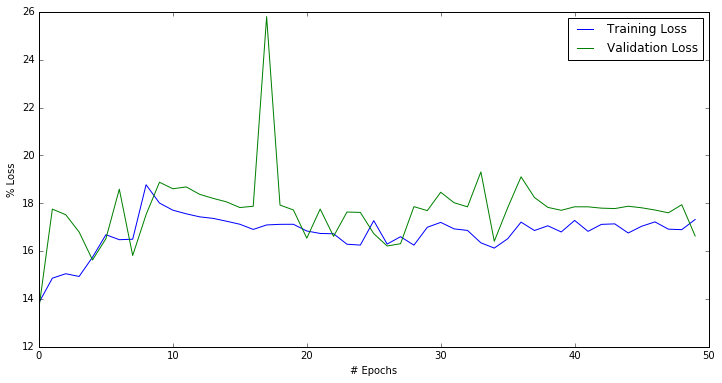

{'acc': [0.9327606538127613,
         0.93138600498265611,
         0.93287869926132905,
         0.93302690052572701,
         0.93096307833070702,
         0.93069282398058495,
         0.93225974499145681,
         0.93108033169211679,
         0.92983548076166578,
         0.93323266230566648,
         0.93364913787455917,
         0.93364276706827853,
         0.93366937141197959,
         0.9337265815348984,
         0.93388752096650229,
         0.93392567069544263,
         0.93392061084681166,
         0.93400333451397843,
         0.9335648810243331,
         0.93350518886753586,
         0.93315117655461921,
         0.93319970438246092,
         0.93353745875331018,
         0.93352876956752273,
         0.93376724809580458,
         0.93258055097105874,
         0.93367652500295917,
         0.93359439531502697,
         0.9334096650167697,
         0.93354270878554768,
         0.93268943453110709,
         0.93371761499801809,
         0.93333640436216581,
         0.933

In [54]:
train_loss = [x * 100 for x in train.history['loss']]
val_loss = [x * 100 for x in train.history['val_loss']]

plt.figure(figsize=(12,6))
ax = plt.subplot(111)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('# Epochs')
plt.ylabel('% Loss')

ax.legend()

plt.show()

from pprint import pprint
#pprint(train.history)

In [49]:
from IPython.display import SVG, Image
import pydot_ng as pydot
import graphviz
import pydot
from keras.utils.visualize_util import model_to_dot, plot


# SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
plot(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename="autoencoder.png")

RuntimeError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.